# Descriptive Text Mining

Programmazione di Applicazioni Data Intensive \
Laurea in Ingegneria e Scienze Informatiche  \
DISI - Università di Bologna, Cesena

<a href="https://colab.research.google.com/github/Da3dalu2/thesis-notebooks/blob/main/notebooks/ntsb_incidents.ipynb#scrollTo=WJb4XfpsyNfa" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Obiettivo: dai rapporti testuali redatti da National Transportation Safety Board che descrivono le cause di incidenti aerei, individuare, mediante analisi semantica con LSA, le cause che contribuiscono a provocare incidenti destroyed.

## Librerie impiegate

In [ ]:
!pip install spacy -U
!python -m spacy download en_core_web_sm

     |████████████████████████████████| 6.0 MB 5.2 MB/s 
     |████████████████████████████████| 10.1 MB 51.3 MB/s 
     |████████████████████████████████| 173 kB 69.9 MB/s 
     |████████████████████████████████| 628 kB 65.1 MB/s 
     |████████████████████████████████| 42 kB 1.5 MB/s 
     |████████████████████████████████| 451 kB 47.3 MB/s 
  Created wheel for langcodes: filename=langcodes-3.2.1-py3-none-any.whl size=169396 sha256=a0dffa16dbdb908499fd605da4f0a188f2e3921c9410ee03eb109fb2d42debb7
  Stored in directory: /root/.cache/pip/wheels/12/9c/b3/d42c928e622075d3b6056733125190086e44c9230878e6eb2b
Successfully built langcodes
  Attempting uninstall: catalogue
    Found existing installation: catalogue 1.0.0
    Uninstalling catalogue-1.0.0:
      Successfully uninstalled catalogue-1.0.0
  Attempting uninstall: srsly
    Found existing installation: srsly 1.0.5
    Uninstalling srsly-1.0.5:
      Successfully uninstalled srsly-1.0.5
  Attempting uninstall: thinc
    Found existing 

In [ ]:
from os import path, makedirs
from tabulate import tabulate
from urllib.request import urlretrieve
import numpy as np
from numpy.linalg import norm
import pandas as pd
import spacy

from matplotlib import pyplot as plt
from matplotlib.colors import from_levels_and_colors
import plotly.graph_objects as go
import plotly.express as px

from scipy.sparse import csr_matrix
from scipy.stats import chi2_contingency

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.utils.extmath import randomized_svd
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
# plt.style.use('science')
images_path = "./"
makedirs(images_path, exist_ok = True)
get_path = lambda fname, format : path.join(images_path, fname + "." + format)
savefig = lambda fname, format : plt.savefig(get_path(fname, format), format = format)

## Funzioni impiegate

In [ ]:
def makequery(qterms, tdm, U, s):
    query = np.zeros(tdm.shape[0])

    # one hot query
    query[[vocabulary.get(term) for term in qterms]] = 1
    # weighted query
    wquery = np.log(query + 1) * (1 - entropy(tdm, axis = 1))
    # folded query
    qls = np.matmul(wquery.T, U)

    # cosine similary query term
    dk = np.matmul(qls, np.diag(np.power(s, -1)))
    dksrs = np.matmul(dk, np.diag(np.sqrt(s)))

    return qterms, query, wquery, qls, dk, dksrs

In [ ]:
def get_matching_docs(a, b):
    a = np.asarray(a)
    b = np.asarray(b)
    return np.isin(a, b).sum()

In [ ]:
def plot_lsa(x,y,terms=None):
    fig = go.Figure()
    
    if terms is None:
        trace = go.Scatter(
            x=x,
            y=y,
            mode="markers+text",
            name="Markers and Text")
    else:
        trace = go.Scatter(
                    x=x,
                    y=y,
                    mode="markers+text",
                    name="Markers and Text",
                    text=terms,
            
                    textposition="bottom center",
                    textfont=dict(
                        family="sans serif",
                        size=9))

    fig.add_trace(trace)
    fig.update_layout(
        height=800,
        template = "none"
    )
    fig.update_traces(marker=dict(size=3,))
    return fig

In [ ]:
def get_terms_arrays(x_coords, y_coords, vocabulary):
    lenght = len(vocabulary)
    x = np.zeros(lenght)
    y = np.zeros(lenght)

    for i, idx in enumerate(vocabulary.values()):
        x[i] = x_coords[idx]
        y[i] = y_coords[idx]
    
    if vocabulary is not None:
        terms = list(vocabulary.keys())
        return (x, y, terms)
    else:
        return (x, y)

In [ ]:
def entropy(m, axis = 0):
    m = np.asarray(m)
    p = 1.0 * m / np.sum(m, axis = axis, keepdims = True)
    ndocs = m.shape[axis]
    vec = (p * np.log(p, out = np.zeros_like(p), where = (p!=0))) / np.log(ndocs)
    entropy = - np.sum(vec, axis = axis)
    return entropy

In [ ]:
def get_word_counts(m, col_mask, row_mask):
    # get only doc_class related docs
    sliced = tdm[:, col_mask]
    
    # slice rows, get only columns with at least one of 
    # the entries in the row mask.
    sliced = sliced[row_mask, :]
    
    with_word = get_occ_word_all_docs(sliced)
    total = col_mask.sum()
    without_word = total - with_word
    return with_word, without_word

def get_occ_word_all_docs(sliced):
    # logical AND applied to all rows, one for each term
    # in the list.
    rows = [row for row in sliced]
    tmp = np.asarray(sliced[0])
    for row in rows:
        b = np.logical_and(tmp, row)
        tmp = b
    b = np.asarray(b)[0]
    return b.sum()

In [ ]:
def term_analysis(
    terms,
    doc_classes,
    without_word_in,
    with_word_in,
    without_word_out,
    with_word_out):  
    
    get_term_doc_df = \
        lambda data, terms, doc_classes : pd.DataFrame(
            data,
            index = [f"not {terms}", f"{terms}"], 
            columns = [f"not {doc_classes}", f"{doc_classes}"]
        )   
    
    terms = "_".join(terms)
    doc_classes = "_".join(doc_classes)
    
    observed = [
        [without_word_out, without_word_in],
        [with_word_out, with_word_in]
    ]
    observed = get_term_doc_df(observed, terms, doc_classes)

    chi2, p, ddof, expected = chi2_contingency(
        observed,
        correction = False
    )
    expected = get_term_doc_df(expected, terms, doc_classes)

    print(f"Pearson's Chi-squared test with {ddof} ddof")
    print("--------------------------------------\n")
    print("Observed frequencies") 
    print(tabulate(observed, headers='keys', tablefmt='psql'))
    print("\nExpected frequencies")
    print(tabulate(expected, headers='keys', tablefmt='psql'))
    print(f"\nX-squared: \t{chi2}")
    print(f"p-value \t{p}")

In [ ]:
def get_similar(m, q, docs, threshold = 0, topn = 10):
    if threshold >= 1.0 or threshold < 0:
        raise("Threshold must be in (0,1]")
    
    docs = np.asarray(docs)
    docs = docs.reshape(docs.shape[0], 1)
    q = np.asarray(q)
    q = q.reshape(1, m.shape[1])
    query2doc = cosine_similarity(q, m)
    query2doc = query2doc.T
    
    mask = query2doc > threshold
    query2doc_masked = query2doc[mask]
    docs_masked = docs[mask]

    docs_idx = [idx for idx, elem in enumerate(mask) if elem == 1]

    # use a structured array
    dtype = [("id", int), ("doc", docs.dtype), ("sim_val", float)]
    ranks = [(z, y, x) for x, y, z in zip(query2doc_masked, docs_masked, docs_idx)]
    ranks = np.array(ranks, dtype = dtype)
    ranks = np.sort(ranks, order = "sim_val")
    ranks = ranks[::-1]  # docs in decreasing order
    
    nranks = len(ranks)
    if topn < nranks:
        ranks = ranks[:topn] # show only first top n matches
        print(f"Selected {topn} of {nranks} matches")
    else:
        print(f"Found {nranks} matches")
    return list(ranks)

## Caricamento dei dati

In [ ]:
import sys
IN_COLAB = 'google.colab' in sys.modules

In [ ]:
dataset_url = "https://raw.githubusercontent.com/Da3dalu2/thesis-notebooks/main/data/ntsb_causes.csv"
dataset_name = "ntsb_causes.csv"
if IN_COLAB:
  data_path = "./"
else:
  data_path = "../data/"

if not path.exists(data_path + dataset_name):
    urlretrieve(dataset_url, dataset_name)

df = pd.read_csv(data_path + dataset_name)  

In [ ]:
df

,damage_class,narr_cause
0,Substantial,The pilot failed to maintain directional contr...
1,Substantial,The pilot's failure to maintain directional co...
2,Destroyed,The failure of the student pilot to maintain a...
3,Substantial,The failure of the pilot to obtain assistance ...
4,Substantial,The pilot's failure to maintain a proper glide...
...,...,...
3224,Substantial,The pilot's failure to properly secure an aeri...
3225,Substantial,the pilot's inadequate compensation for the gu...
3226,Substantial,The student's failure to maintain adequate mai...
3227,Substantial,The certified flight instructor (CFI) delayed ...


In [ ]:
damage_class = list(df.damage_class.unique())

In [ ]:
fig = go.Figure(
    data = [go.Pie(labels = damage_class,
            values = df.damage_class.value_counts(),
            marker = dict(colors = px.colors.qualitative.Bold),
            hole = .3)]
)

fig.update_layout(title = "Distribuzione dell'esito degli incidenti aerei")
fig.show()

## Costruzione della matrice termini documenti

In [ ]:
excluded = [
#     "tok2vec",
#     "tagger",
#     "parser",
    "ner",
#     "attribute_ruler",
#     "lemmatizer"
]
nlp = spacy.load("en_core_web_sm", exclude=excluded)
# nlp.Defaults.stop_words |= {"effect", "effects"}

In [ ]:
def spacy_tokenizer(sentence):
    sentence = nlp(sentence)
    tokens = [token.lemma_.lower() for token in sentence 
          if token.is_stop == False 
          and token.is_punct == False
          and len(token.text) > 2
          and token.is_ascii == True
          and token.is_alpha == True
          and token.is_quote == False
          and token.is_space == False
          and token.is_currency == False
          and token.like_email == False
          and token.like_num == False
          and token.like_url == False
         ]
    return tokens

In [ ]:
df.columns

Index(['damage_class', 'narr_cause'], dtype='object')

In [ ]:
min_df_one_percent = int(df.narr_cause.count() / 100)
min_df_one_percent

32

In [ ]:
vect = CountVectorizer(
    strip_accents = "ascii",
    tokenizer = spacy_tokenizer,
    min_df = min_df_one_percent
)
dtm = vect.fit_transform(df.narr_cause)
tdm = dtm.transpose()

# adding a nonzero scalar to a sparse matrix is not supported
tdm = tdm.todense()

b = (1 - entropy(tdm, axis = 1))
b = np.array(b)

a = np.log(tdm + 1)
a = np.array(a)

wtdm = (a.T * b).T
wtdm = csr_matrix(wtdm)

In [ ]:
dtm

<3229x202 sparse matrix of type '<class 'numpy.int64'>'
	with 35441 stored elements in Compressed Sparse Row format>

In [ ]:
ord_terms = vect.get_feature_names()

In [ ]:
vocabulary = vect.vocabulary_

In [ ]:
dtm.astype(bool).mean()

0.05455688420702311

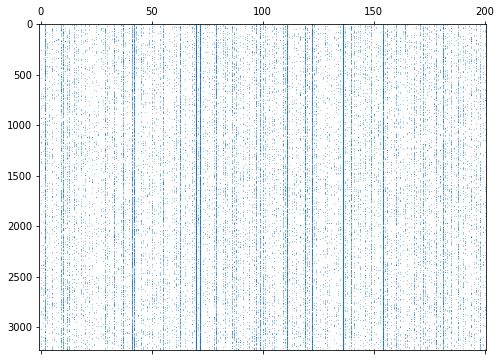

In [ ]:
fig = plt.figure()
plt.spy(dtm, markersize=0.10, aspect = 'auto')
fig.set_size_inches(8,6)

## Analisi semantica latente

In [ ]:
U, s, Vh = randomized_svd(wtdm, n_components = 69, random_state = 5)

In [ ]:
s.shape

(69,)

In [ ]:
U.shape

(201, 69)

In [ ]:
Vh.shape

(69, 3229)

In [ ]:
Vh = Vh.transpose()

In [ ]:
Vh.shape

(3229, 69)

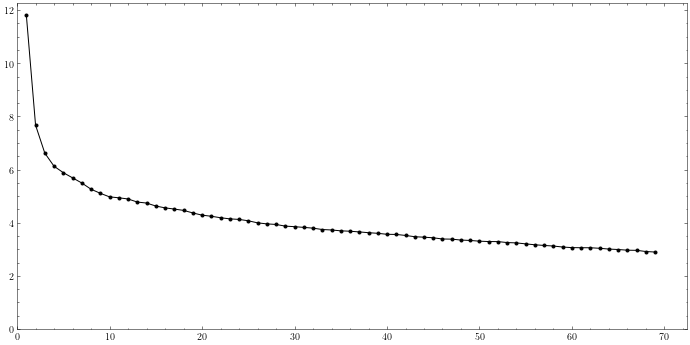

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(np.linspace(1, 69, 69), s, "k.-")
plt.ylim(bottom=0)
plt.xlim(xmin=0)
savefig("power_law_svd", "pdf")

In [ ]:
# U è chiamata tk (lsar$tk), S è sk (lsar$sk), V^t è dk (lsar$dk)
tls = np.matmul(U, np.diag(s))
dls = np.matmul(Vh, np.diag(s))

In [ ]:
tls.shape

(201, 69)

In [ ]:
dls.shape

(3229, 69)

## Visualizzazione dello spazio trasformato

In [ ]:
get_norm = lambda v : np.sqrt(np.sum(np.power(v, 2)))

In [ ]:
terms_norm_lsa = np.zeros(len(tls[:,]))
for idx, col in enumerate(tls):
    terms_norm_lsa[idx] = get_norm(col)

In [ ]:
tls_terms_norm = np.column_stack((tls, terms_norm_lsa))
tls_terms_norm.shape

(201, 70)

Visualizzazione dei termini nelle prime due dimensioni latenti

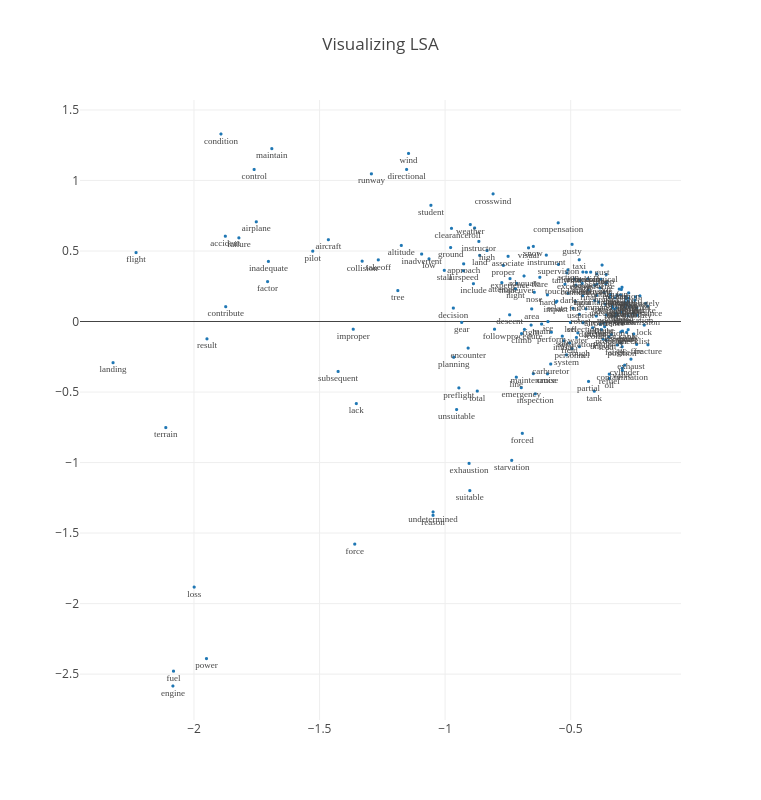

In [ ]:
x, y, terms = get_terms_arrays(-1*tls[:,0], -1*tls[:,1], vocabulary)
plot_lsa(x, y, terms) \
    .update_layout(title_text = "Visualizing LSA") \
    .show()

In [ ]:
tls.shape

(201, 69)

In [ ]:
tls_terms_norm.shape

(201, 70)

In [ ]:
vocabulary_reduced = {}
for term, idx in vocabulary.items():
    if tls_terms_norm[idx][69] > 1.25: 
        vocabulary_reduced[term] = idx

In [ ]:
len(vocabulary_reduced)

178

In [ ]:
x.shape

(201,)

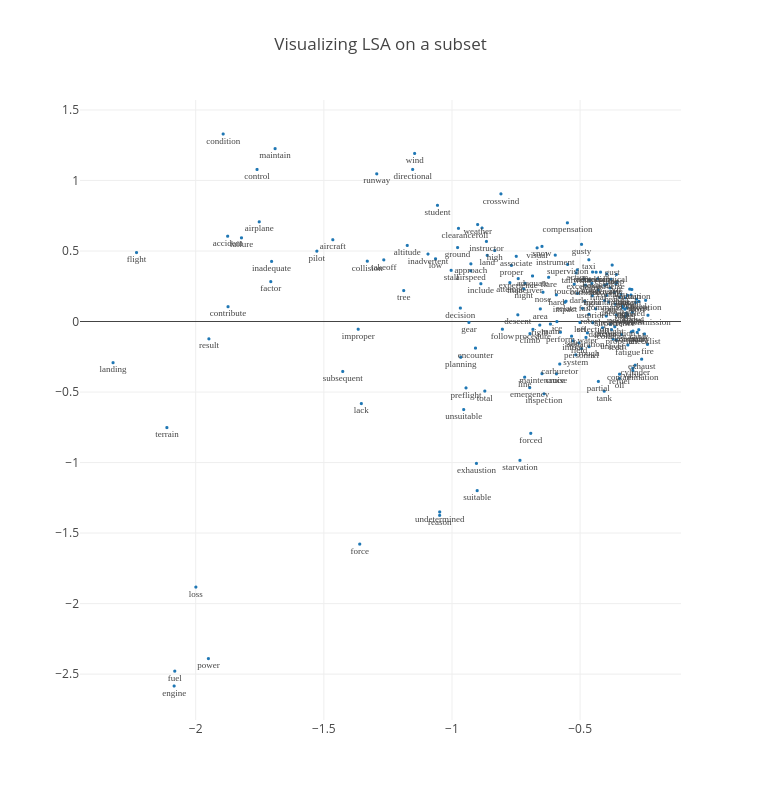

In [ ]:
x, y, terms = get_terms_arrays(-1*tls[:,0], -1*tls[:,1], vocabulary_reduced)
plot_lsa(x, y, terms) \
    .update_layout(title_text = "Visualizing LSA on a subset") \
    .show()

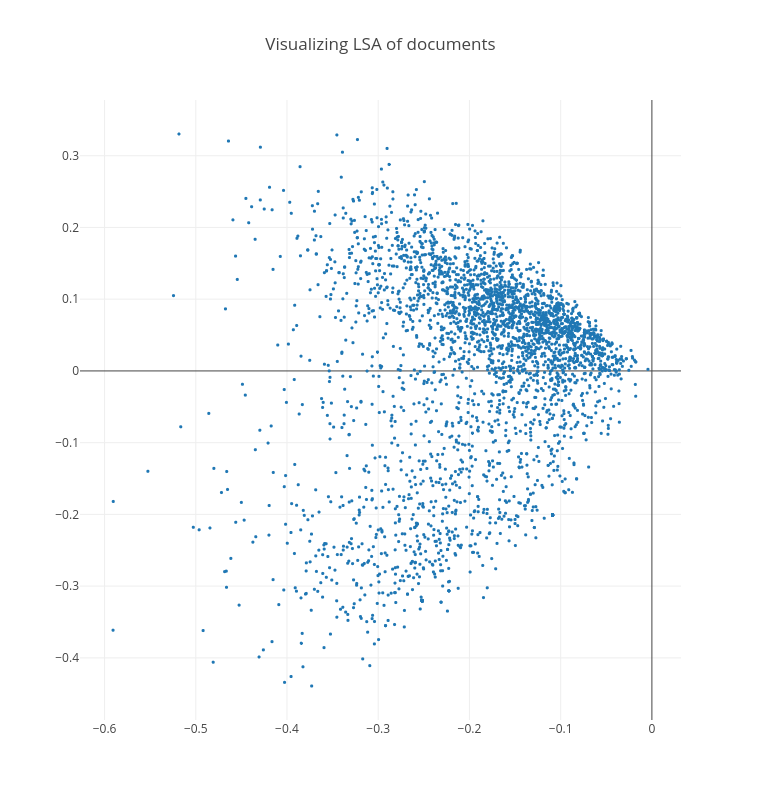

In [ ]:
plot_lsa(-1*dls[:,0], -1*dls[:,1]) \
    .update_layout(title_text = "Visualizing LSA of documents") \
    .show()

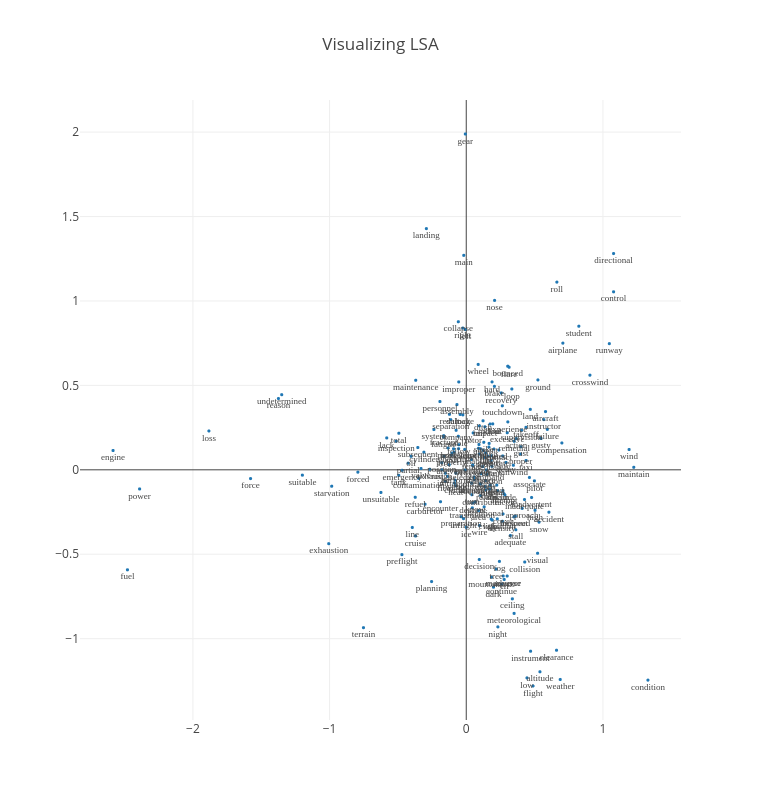

In [ ]:
x, y, terms = get_terms_arrays(-1*tls[:,1], tls[:,2], vocabulary)
plot_lsa(x, y, terms) \
    .update_layout(title_text = "Visualizing LSA") \
    .show()

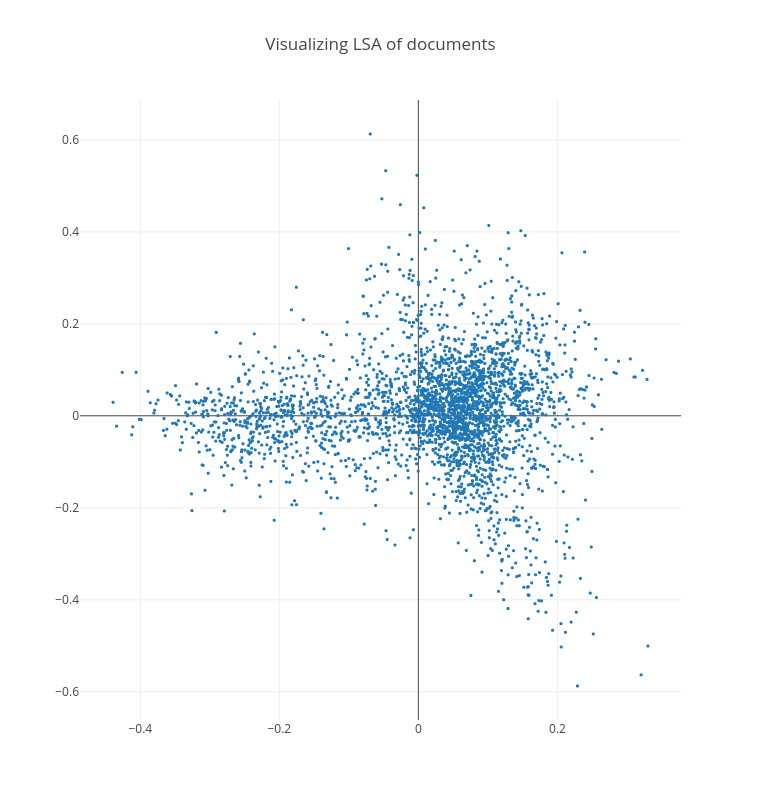

In [ ]:
plot_lsa(-1*dls[:,1], dls[:,2]) \
    .update_layout(title_text = "Visualizing LSA of documents") \
    .show()

## Distribuzione delle tipologie di incidenti

In [ ]:
df.damage_class.value_counts()

Substantial    2574
Destroyed       482
None             91
Minor            82
Name: damage_class, dtype: int64

In [ ]:
dls.shape

(3229, 69)

In [ ]:
df

,damage_class,narr_cause
0,Substantial,The pilot failed to maintain directional contr...
1,Substantial,The pilot's failure to maintain directional co...
2,Destroyed,The failure of the student pilot to maintain a...
3,Substantial,The failure of the pilot to obtain assistance ...
4,Substantial,The pilot's failure to maintain a proper glide...
...,...,...
3224,Substantial,The pilot's failure to properly secure an aeri...
3225,Substantial,the pilot's inadequate compensation for the gu...
3226,Substantial,The student's failure to maintain adequate mai...
3227,Substantial,The certified flight instructor (CFI) delayed ...


In [ ]:
dfc = pd.DataFrame(
    {"Esito incidente" : df.damage_class,
     "dls[:,1]" : -1*dls[:,1],
     "dls[:,2]" : dls[:,2]}
)

In [ ]:
fig = px.scatter(
    dfc,
    x="dls[:,1]",
    y="dls[:,2]",
    color="Esito incidente",
    template="none",
    height=800
)
    
fig.update_traces(marker=dict(size=3,))
fig.show()

## Analisi termini e documenti

In [ ]:
tlsn = norm(tls, 2, axis = 1)
dlsn = norm(dls, 2, axis = 1)
tlsn = tls / tlsn[:,None]
dlsn = dls / dlsn[:,None]

In [ ]:
dfc = pd.DataFrame(
    {"Esito incidente" : df.damage_class,
     "dls[:,1]" : -1*dlsn[:,1],
     "dls[:,2]" : dlsn[:,2]}
)

In [ ]:
x, y, terms = get_terms_arrays(-1*tlsn[:,1], tlsn[:,2], vocabulary)

In [ ]:
fig = px.scatter(
    dfc,
    x = "dls[:,1]",
    y = "dls[:,2]",
    color = "Esito incidente",
    template = "none",
    height = 800
)

terms_trace = go.Scatter(
    x = x,
    y = y,
    mode = "markers+text",
    name = "terms",
    text = terms,
    textposition = "bottom center",
    textfont = 
        dict(
            family = "sans serif",
            size = 9
        )
)
    
fig.add_trace(terms_trace)
fig.update_traces(marker=dict(size=3,))
fig.show()

## Analisi del termine weather

In [ ]:
terms = ["weather"]
doc_classes = ["Destroyed"]

doc_idx = np.asarray(df.damage_class == doc_classes[0])
doc_mask = doc_idx != 0

term_idx = [vocabulary.get(term) for term in terms]
term_mask = np.zeros(tdm.shape[0], dtype = bool)
term_mask[term_idx] = True

with_word_in, without_word_in = get_word_counts(tdm, doc_mask, term_mask)

doc_mask = ~doc_mask

with_word_out, without_word_out = get_word_counts(tdm, doc_mask, term_mask)

term_analysis(
    terms,
    doc_classes,
    without_word_in,
    with_word_in,
    without_word_out,
    with_word_out
)

Pearson's Chi-squared test with 1 ddof
--------------------------------------

Observed frequencies
+-------------+-----------------+-------------+
|             |   not Destroyed |   Destroyed |
|-------------+-----------------+-------------|
| not weather |            2664 |         428 |
| weather     |              83 |          54 |
+-------------+-----------------+-------------+

Expected frequencies
+-------------+-----------------+-------------+
|             |   not Destroyed |   Destroyed |
|-------------+-----------------+-------------|
| not weather |         2630.45 |    461.55   |
| weather     |          116.55 |     20.4503 |
+-------------+-----------------+-------------+

X-squared: 	67.56407215908636
p-value 	2.0395037376620448e-16


In [ ]:
m = tls[:,1:3]
term = "weather"
term_id = vocabulary.get(term)

ranks = get_similar(
    m,
    m[term_id, ],
    ord_terms,
    threshold = 0.8,
    topn = 20
)
ranks = ranks[1:]    # exclude term used for search
ranks

Selected 20 of 57 matches


[(107, 'intentional', 0.99946273),
 (29, 'clearance', 0.99884444),
 (11, 'airport', 0.99875352),
 (114, 'light', 0.99862643),
 (7, 'adverse', 0.99811396),
 (80, 'fly', 0.99800418),
 (13, 'altitude', 0.99663358),
 (81, 'fog', 0.9963874),
 (27, 'ceiling', 0.99596301),
 (106, 'instrument', 0.9957089),
 (41, 'contribute', 0.99511274),
 (124, 'maneuver', 0.99503091),
 (193, 'vfr', 0.99481907),
 (125, 'meteorological', 0.99338559),
 (79, 'flight', 0.99008725),
 (40, 'continue', 0.99004032),
 (185, 'tree', 0.9889874),
 (16, 'area', 0.98861357),
 (64, 'evaluation', 0.98764673)]

In [ ]:
terms = ["adverse", "weather"]
doc_classes = ["Destroyed"]

doc_idx = np.asarray(df.damage_class == doc_classes[0])
doc_mask = doc_idx != 0

term_idx = [vocabulary.get(term) for term in terms]
term_mask = np.zeros(tdm.shape[0], dtype = bool)
term_mask[term_idx] = True

with_word_in, without_word_in = get_word_counts(tdm, doc_idx, term_mask)

doc_mask = ~doc_mask

with_word_out, without_word_out = get_word_counts(tdm, doc_mask, term_mask)

term_analysis(
    terms,
    doc_classes,
    without_word_in,
    with_word_in,
    without_word_out,
    with_word_out
)

Pearson's Chi-squared test with 1 ddof
--------------------------------------

Observed frequencies
+---------------------+-----------------+-------------+
|                     |   not Destroyed |   Destroyed |
|---------------------+-----------------+-------------|
| not adverse_weather |            2724 |         457 |
| adverse_weather     |              23 |          25 |
+---------------------+-----------------+-------------+

Expected frequencies
+---------------------+-----------------+-------------+
|                     |   not Destroyed |   Destroyed |
|---------------------+-----------------+-------------|
| not adverse_weather |       2706.17   |   474.835   |
| adverse_weather     |         40.8349 |     7.16507 |
+---------------------+-----------------+-------------+

X-squared: 	52.97079799097852
p-value 	3.3854428665485344e-13


## Costruzione di un'interrogazione semplice

In [ ]:
qterms = ["adverse", "weather"]
query = np.zeros(tdm.shape[0])
query[[vocabulary.get(term) for term in qterms]] = 1
query.shape

(201,)

In [ ]:
wquery = np.log(query + 1) * (1 - entropy(tdm, axis = 1))
wquery.shape

(201,)

In [ ]:
qls = np.matmul(wquery.T, U)
qls.shape

(69,)

In [ ]:
qlsn = norm(qls, 2)
qlsn = qls / qlsn

In [ ]:
qlsn[2]

-0.23644672976755834

In [ ]:
qlsn[3]

-0.011162876315712828

In [ ]:
x, y, terms = get_terms_arrays(-1*tlsn[:,1], tlsn[:,2], vocabulary)

In [ ]:
fig = px.scatter(
    dfc,
    x = "dls[:,1]",
    y = "dls[:,2]",
    color = "Esito incidente",
    template = "none",
    height = 800
)

terms_trace = go.Scatter(
    x = x,
    y = y,
    mode = "markers+text",
    name = "terms",
    text = terms,
    textposition = "bottom center",
    textfont = 
        dict(
            family = "sans serif",
            size = 9
        )
)

query_trace = go.Scatter(
    x = [-1*qlsn[1]],
    y = [qlsn[2]],
    mode = "markers",
    name = "query",
    marker = dict(
        size = 12,
        color = "black",
        symbol = "x"
    )
)

fig.add_trace(terms_trace)
fig.update_traces(marker=dict(size=3,))
fig.add_trace(query_trace)
fig.show()

In [ ]:
m = dls[:,1:3]
q = qls[1:3]
docs = df.narr_cause.values

ranks = get_similar(
    m,
    q,
    docs,
    threshold = 0.8,
    topn = 10
)
[rank for rank in ranks]

Selected 10 of 641 matches


[(2249, "The pilot's inadequate in-flight planning/decision resulting in the misconfiguration of the flaps and the elevator trim setting.  The misconfiguration resulted in an inadvertent pitch-up, loss of airspeed, stall and collision with the ground.", 1.),
 (1830, "The pilot's intentional continuation of a visual flight rules (VFR)  flight into instrument meteorological conditions (IMC), and his failure to maintain clearance from the terrain. Factors include low ceilings, snow, mountainous/hilly terrain, and trees.", 0.99999912),
 (1040, "the pilot's inadvertent visual flight rules ( VFR)  flight into instrument meteorological conditions (IMC) during cruise flight. Factors include his attention being diverted to the indications presented by his Global Positioning System (GPS), and low ceiling and clouds in the area he was transiting.", 0.99999804),
 (2599, "The pilot's failure to maintain adequate altitude and clearance in hilly terrain.  A factor contributing to the accident was the

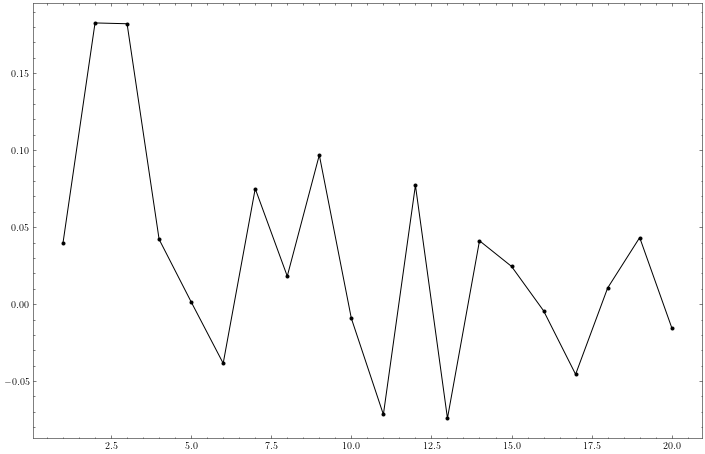

In [ ]:
fordiff = lambda x : x[1:len(x)] - x[0:(len(x) - 1)]
skd = fordiff(s)
skdd = fordiff(skd)
skcurv = skdd[0:20] / np.power(1 + np.power(skd[0:20], 2), 1.5)

plt.figure(figsize=(12, 8))
plt.plot(np.linspace(1, 20, 20), skcurv, "k.-")
savefig("knee_points_svd", "pdf")

In [ ]:
m = dls[:,0:6]
q = qls[0:6]
docs = df.narr_cause

ranks = get_similar(
    m,
    q,
    docs,
    threshold = 0.2,
    topn = 482
)
query_matching_idxs = [rank[0] for rank in ranks]
sim_scores = [rank[2] for rank in ranks]

Selected 482 of 1069 matches


In [ ]:
[rank[1] for rank in ranks[:10]]

["pilot's continued visual flight into instrument meteorological conditions.",
 "The pilot's continued flight into instrument meteorological conditions.  Contributing factors were fog, low ceilings, drizzle/mist, rising terrain, and the non-availability of a functioning transponder.",
 "The pilot's spatial disorientation due to a night visual illusion.  A factor was the dark night condition.",
 "The pilot's continued flight into known adverse weather.  A factor was the snow.",
 "The pilot's poor judgment in that he intentionally initiated VFR flight into instrument meteorological conditions.  Contributing factors were low ceiling and obscuration, and the pilot's lack of recent instrument time.",
 "The pilot's disregard of  the weather evaluation and his attempt to fly into known adverse weather without an instrument rating.  Factors in the accident were the low ceiling, the low visibility, and the icing conditions.",
 "The pilot's continued VFR flight into instrument meteorological con

In [ ]:
df.damage_class[query_matching_idxs[0:10]].value_counts()

Substantial    5
Destroyed      5
Name: damage_class, dtype: int64

In [ ]:
df.damage_class.value_counts()

Substantial    2574
Destroyed       482
None             91
Minor            82
Name: damage_class, dtype: int64

In [ ]:
df.damage_class[query_matching_idxs].value_counts()

Substantial    288
Destroyed      161
None            23
Minor           10
Name: damage_class, dtype: int64

In [ ]:
doc_classes = ["Destroyed"]
terms = ["adverse", "weather"]
destroyed_idx = np.asarray(df.damage_class == doc_classes[0])
doc_mask = destroyed_idx != 0

query_mask = np.zeros(dls.shape[0])
query_mask[query_matching_idxs] = 1

mask = np.logical_and(doc_mask, query_mask)
total = doc_mask.sum()
with_word_in = mask.sum()
without_word_in = total - with_word_in

doc_mask = ~doc_mask
mask = np.logical_and(doc_mask, query_mask)
total = doc_mask.sum()
with_word_out = mask.sum()
without_word_out = total - with_word_out

term_analysis(
    terms,
    doc_classes,
    without_word_in,
    with_word_in,
    without_word_out,
    with_word_out
)

Pearson's Chi-squared test with 1 ddof
--------------------------------------

Observed frequencies
+---------------------+-----------------+-------------+
|                     |   not Destroyed |   Destroyed |
|---------------------+-----------------+-------------|
| not adverse_weather |            2426 |         321 |
| adverse_weather     |             321 |         161 |
+---------------------+-----------------+-------------+

Expected frequencies
+---------------------+-----------------+-------------+
|                     |   not Destroyed |   Destroyed |
|---------------------+-----------------+-------------|
| not adverse_weather |        2336.95  |    410.051  |
| adverse_weather     |         410.051 |     71.9492 |
+---------------------+-----------------+-------------+

X-squared: 	152.28891417979148
p-value 	5.478756017747545e-35


In [ ]:
destroyed_entries = np.asarray(
    [1 if destroyed_idx[idx] == 1 else 0 for idx in query_matching_idxs]
)

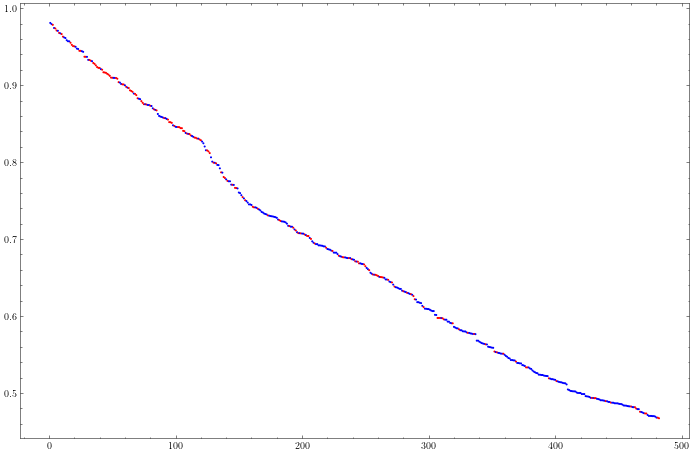

In [ ]:
plt.figure(figsize=(12, 8))
plt.scatter(
    np.linspace(1, 482, 482),
    sim_scores,
    c = destroyed_entries,
    marker = "o",
    cmap = "bwr",
    s = 1
)
plt.show()

## Costruzione di un'interrogazione articolata

In [ ]:
tlsn = norm(tls[:,0:6], 2, axis = 1)

In [ ]:
qterms = ["adverse", "weather"]
_, _, _, qls, _, _ = makequery(qterms, tdm, U, s);
ranks = get_similar(
    dls[:,0:6],
    qls[0:6],
    df.narr_cause,
    threshold = 0.2,
    topn = 482
)
docs_matching_query_2 = [rank[0] for rank in ranks]

Selected 482 of 1144 matches


In [ ]:
# [rank[1] for rank in ranks[:10]]

In [ ]:
ranks = get_similar(
    tls[:,0:6],
    qls[0:6],
    ord_terms,
    threshold = 0.2,
    topn = 482
)

Found 84 matches


In [ ]:
sim_scores_reduced = [rank for rank in ranks if rank[2] > 0.92]
sim_scores_reduced_idx = [rank[0] for rank in sim_scores_reduced]
norms = tlsn[sim_scores_reduced_idx]
[(rank[2], norm, rank[1]) for rank, norm in zip(sim_scores_reduced, norms)]

[(0.9797430331617991, 0.9108828926919034, 'adverse'),
 (0.9717413436369489, 1.9481984097275264, 'weather'),
 (0.9717324834279831, 0.946162559791531, 'vfr'),
 (0.9637723791398514, 1.2162988533627574, 'meteorological'),
 (0.9523551915651138, 0.7571045149564712, 'fog'),
 (0.9470297755971868, 0.8925661790914144, 'mountainous'),
 (0.9436167770994602, 1.5522192056299544, 'instrument'),
 (0.9355617988777334, 1.0238275074358427, 'dark'),
 (0.9326408612624346, 1.3938789962689166, 'night'),
 (0.9291645191481028, 1.0835294970940692, 'ceiling')]

In [ ]:
qterms = ["adverse", "weather", "instrument"]
_, _, _, qls, _, _ = makequery(qterms, tdm, U, s);
ranks = get_similar(
    dls[:,0:6],
    qls[0:6],
    df.narr_cause,
    threshold = 0.2,
    topn = 482
)
docs_matching_query_3 = [rank[0] for rank in ranks]

Selected 482 of 1094 matches


In [ ]:
# [rank[1] for rank in ranks[:10]]

In [ ]:
ranks = get_similar(
    tls[:,0:6],
    qls[0:6],
    ord_terms,
    threshold = 0.2,
    topn = 482
)

Found 85 matches


In [ ]:
sim_scores_reduced = [rank for rank in ranks if rank[2] > 0.92]
sim_scores_reduced_idx = [rank[0] for rank in sim_scores_reduced]
norms = tlsn[sim_scores_reduced_idx]
[(rank[2], norm, rank[1]) for rank, norm in zip(sim_scores_reduced, norms)]

[(0.9868928076789402, 0.946162559791531, 'vfr'),
 (0.9855568354482984, 1.2162988533627574, 'meteorological'),
 (0.978198405094489, 0.9108828926919034, 'adverse'),
 (0.9722504416850062, 0.7571045149564712, 'fog'),
 (0.9703432522998183, 1.5522192056299544, 'instrument'),
 (0.9645823881266132, 0.8925661790914144, 'mountainous'),
 (0.9609507146032727, 1.0835294970940692, 'ceiling'),
 (0.9567910605490977, 1.9481984097275264, 'weather'),
 (0.9500959730303234, 1.0238275074358427, 'dark'),
 (0.9431031942610328, 1.3938789962689166, 'night'),
 (0.9259378598043291, 1.0070405351925207, 'continue')]

In [ ]:
get_matching_docs(docs_matching_query_2, docs_matching_query_3)

447

In [ ]:
qterms = ["adverse", "weather", "instrument", "meteorological"]
_, _, _, qls, _, _ = makequery(qterms, tdm, U, s);
ranks = get_similar(
    dls[:,0:6],
    qls[0:6],
    df.narr_cause,
    threshold = 0.2,
    topn = 482
)
docs_matching_query_4 = [rank[0] for rank in ranks]

Selected 482 of 1053 matches


In [ ]:
# [rank[1] for rank in ranks[:10]]

In [ ]:
ranks = get_similar(
    tls[:,0:6],
    qls[0:6],
    ord_terms,
    threshold = 0.2,
    topn = 482
)

Found 85 matches


In [ ]:
sim_scores_reduced = [rank for rank in ranks if rank[2] > 0.92]
sim_scores_reduced_idx = [rank[0] for rank in sim_scores_reduced]
norms = tlsn[sim_scores_reduced_idx]
[(rank[2], norm, rank[1]) for rank, norm in zip(sim_scores_reduced, norms)]

[(0.9876496001727312, 1.2162988533627574, 'meteorological'),
 (0.986690946604063, 0.946162559791531, 'vfr'),
 (0.9731747058783794, 1.5522192056299544, 'instrument'),
 (0.9725441664979837, 0.7571045149564712, 'fog'),
 (0.9719522280451794, 0.9108828926919034, 'adverse'),
 (0.9652444794196247, 1.0835294970940692, 'ceiling'),
 (0.9646444748218211, 0.8925661790914144, 'mountainous'),
 (0.9491010522537346, 1.0238275074358427, 'dark'),
 (0.9460055495017523, 1.9481984097275264, 'weather'),
 (0.9410550322622876, 1.3938789962689166, 'night'),
 (0.927086560592369, 1.0070405351925207, 'continue')]

In [ ]:
get_matching_docs(docs_matching_query_2, docs_matching_query_4)

436

In [ ]:
qterms = ["adverse", "weather", "instrument", "meteorological", "continue"]
_, _, _, qls, _, _ = makequery(qterms, tdm, U, s);
ranks = get_similar(
    dls[:,0:6],
    qls[0:6],
    df.narr_cause,
    threshold = 0.2,
    topn = 482
)
docs_matching_query_5 = [rank[0] for rank in ranks]

Selected 482 of 1081 matches


In [ ]:
# [rank[1] for rank in ranks[:10]]

In [ ]:
ranks = get_similar(
    tls[:,0:6],
    qls[0:6],
    ord_terms,
    threshold = 0.2,
    topn = 482
)

Found 85 matches


In [ ]:
sim_scores_reduced = [rank for rank in ranks if rank[2] > 0.92]
sim_scores_reduced_idx = [rank[0] for rank in sim_scores_reduced]
norms = tlsn[sim_scores_reduced_idx]
[(rank[2], norm, rank[1]) for rank, norm in zip(sim_scores_reduced, norms)]

[(0.9899041702647583, 1.2162988533627574, 'meteorological'),
 (0.98754647135718, 0.946162559791531, 'vfr'),
 (0.9773200629328563, 0.7571045149564712, 'fog'),
 (0.9769975773985855, 1.5522192056299544, 'instrument'),
 (0.9720574758194843, 1.0835294970940692, 'ceiling'),
 (0.9714299347374035, 0.9108828926919034, 'adverse'),
 (0.9659131140259687, 0.8925661790914144, 'mountainous'),
 (0.9559861805430034, 1.0238275074358427, 'dark'),
 (0.9479793439935822, 1.3938789962689166, 'night'),
 (0.9419598659313795, 1.9481984097275264, 'weather'),
 (0.9401184393168878, 1.0070405351925207, 'continue')]

In [ ]:
get_matching_docs(docs_matching_query_2, docs_matching_query_5)

426

In [ ]:
qterms = ["adverse", "weather", "instrument", "meteorological", "continue", "vfr"]
_, _, _, qls, _, _ = makequery(qterms, tdm, U, s);
ranks = get_similar(
    dls[:,0:6],
    qls[0:6],
    df.narr_cause,
    threshold = 0.2,
    topn = 482
)
docs_matching_query_6 = [rank[0] for rank in ranks]

Selected 482 of 1069 matches


In [ ]:
# [rank[1] for rank in ranks[:10]]

In [ ]:
ranks = get_similar(
    tls[:,0:6],
    qls[0:6],
    ord_terms,
    threshold = 0.2,
    topn = 482
)

Found 85 matches


In [ ]:
sim_scores_reduced = [rank for rank in ranks if rank[2] > 0.92]
sim_scores_reduced_idx = [rank[0] for rank in sim_scores_reduced]
norms = tlsn[sim_scores_reduced_idx]
[(rank[2], norm, rank[1]) for rank, norm in zip(sim_scores_reduced, norms)]

[(0.989647401285946, 1.2162988533627574, 'meteorological'),
 (0.9870228987738877, 0.946162559791531, 'vfr'),
 (0.976549673610269, 1.5522192056299544, 'instrument'),
 (0.9759578768866864, 0.7571045149564712, 'fog'),
 (0.9713134902732615, 1.0835294970940692, 'ceiling'),
 (0.969562536253852, 0.9108828926919034, 'adverse'),
 (0.965425644965243, 0.8925661790914144, 'mountainous'),
 (0.9542878742673186, 1.0238275074358427, 'dark'),
 (0.9461108061997555, 1.3938789962689166, 'night'),
 (0.9397001989670111, 1.9481984097275264, 'weather'),
 (0.9375820601160997, 1.0070405351925207, 'continue')]

In [ ]:
get_matching_docs(docs_matching_query_2, docs_matching_query_6)

424

In [ ]:
doc_classes = ["Destroyed"]
qterms = ["adverse", "weather", "instrument", "meteorological", "continue", "vfr"]
destroyed_idx = np.asarray(df.damage_class == doc_classes[0])
doc_mask = destroyed_idx != 0

query_mask = np.zeros(dls.shape[0])
query_mask[docs_matching_query_6] = 1

mask = np.logical_and(doc_mask, query_mask)
total = doc_mask.sum()
with_word_in = mask.sum()
without_word_in = total - with_word_in

doc_mask = ~doc_mask
mask = np.logical_and(doc_mask, query_mask)
total = doc_mask.sum()
with_word_out = mask.sum()
without_word_out = total - with_word_out

term_analysis(
    qterms,
    doc_classes,
    without_word_in,
    with_word_in,
    without_word_out,
    with_word_out
)

Pearson's Chi-squared test with 1 ddof
--------------------------------------

Observed frequencies
+------------------------------------------------------------+-----------------+-------------+
|                                                            |   not Destroyed |   Destroyed |
|------------------------------------------------------------+-----------------+-------------|
| not adverse_weather_instrument_meteorological_continue_vfr |            2426 |         321 |
| adverse_weather_instrument_meteorological_continue_vfr     |             321 |         161 |
+------------------------------------------------------------+-----------------+-------------+

Expected frequencies
+------------------------------------------------------------+-----------------+-------------+
|                                                            |   not Destroyed |   Destroyed |
|------------------------------------------------------------+-----------------+-------------|
| not adverse_weather_i